In [29]:
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt

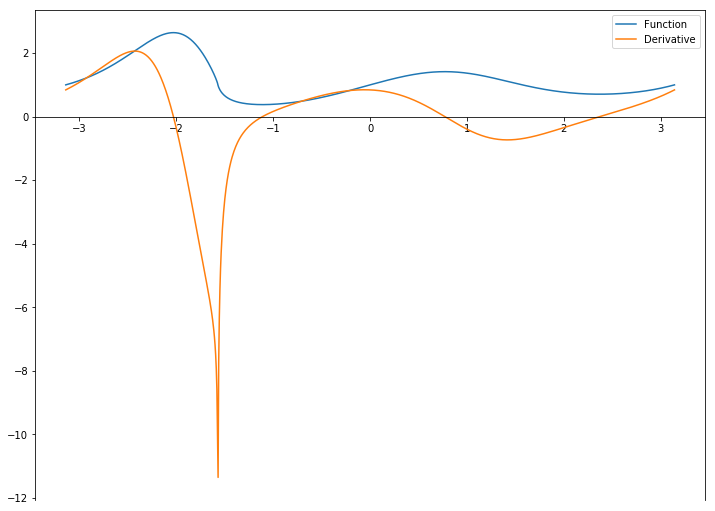

In [114]:
def get_functions():
    x = sy.symbols('x')
    representation = (sy.sin(x) + 1) ** (sy.sin(sy.cos(x)))
    function = sy.lambdify(x, representation, 'numpy')
    derivative = sy.lambdify(x, sy.diff(representation, x), 'numpy')
    return function, derivative

function, derivative = get_functions()

domain = np.linspace(-np.pi, np.pi, 1000)
plt.subplots(figsize=(12, 9))
ax = plt.gca()
ax.spines["bottom"].set_position("zero")
plt.plot(domain, function(domain), label='Function')
plt.plot(domain, derivative(domain), label='Derivative')
plt.legend()
plt.show()

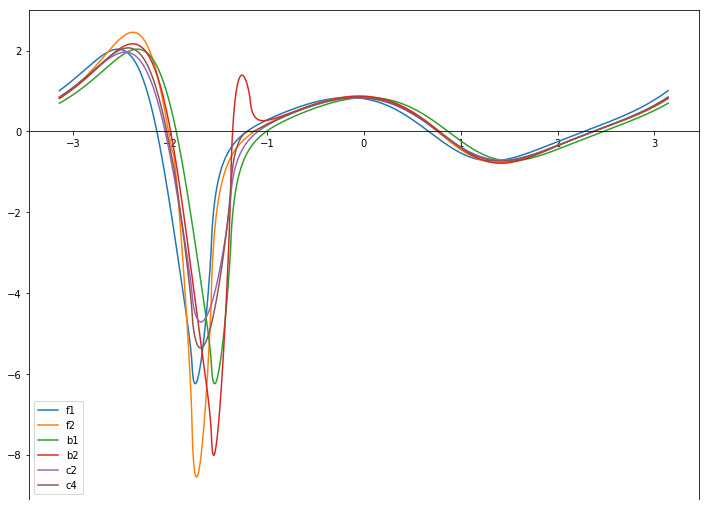

In [115]:
def f1(f, x_arr, h):
    return (f(x_arr + h) - f(x_arr)) / h

def f2(f, x_arr, h):
    return (-3*f(x_arr) + 4*f(x_arr + h) - f(x_arr + 2*h)) / (2*h)

def b1(f, x_arr, h):
    return (f(x_arr) - f(x_arr - h)) / h

def b2(f, x_arr, h):
    return (3*f(x_arr) - 4*f(x_arr - h) + f(x_arr - 2*h)) / (2*h)

def c2(f, x_arr, h):
    return (f(x_arr + h) - f(x_arr - h)) / (2*h)

def c4(f, x_arr, h):
    return (f(x_arr - 2*h) - 8*f(x_arr - h) + 8*f(x_arr + h) - f(x_arr + 2*h)) / (12*h)

h = 0.2
plt.subplots(figsize=(12, 9))
ax = plt.gca()
ax.spines["bottom"].set_position("zero")
plt.plot(domain, f1(function, domain, h), label='f1')
plt.plot(domain, f2(function, domain, h), label='f2')
plt.plot(domain, b1(function, domain, h), label='b1')
plt.plot(domain, b2(function, domain, h), label='b2')
plt.plot(domain, c2(function, domain, h), label='c2')
plt.plot(domain, c4(function, domain, h), label='c4')
plt.legend()
plt.show()

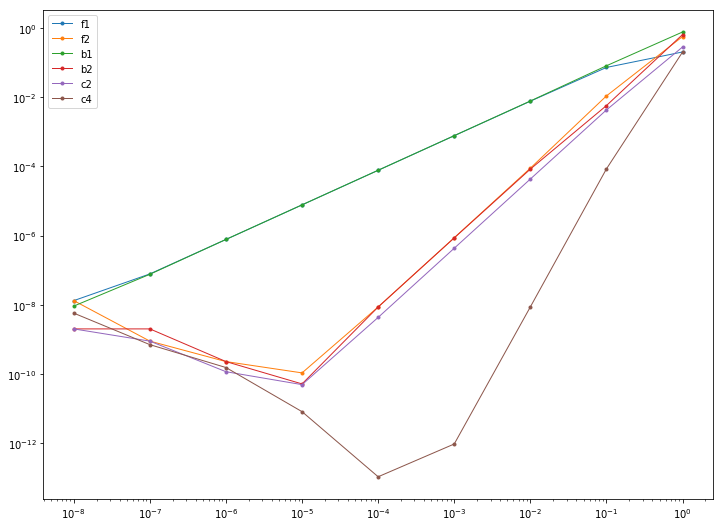

In [117]:
def derivative_errors(x_0):
    true_val = derivative(x_0)
    h_vals = np.logspace(-8, 0, 9)
    plt.subplots(figsize=(12, 9))
    plt.loglog(h_vals, [abs(true_val - f1(function, x_0, h)) for h in h_vals], label='f1', marker='.', lw=1)
    plt.loglog(h_vals, [abs(true_val - f2(function, x_0, h)) for h in h_vals], label='f2', marker='.', lw=1)
    plt.loglog(h_vals, [abs(true_val - b1(function, x_0, h)) for h in h_vals], label='b1', marker='.', lw=1)
    plt.loglog(h_vals, [abs(true_val - b2(function, x_0, h)) for h in h_vals], label='b2', marker='.', lw=1)
    plt.loglog(h_vals, [abs(true_val - c2(function, x_0, h)) for h in h_vals], label='c2', marker='.', lw=1)
    plt.loglog(h_vals, [abs(true_val - c4(function, x_0, h)) for h in h_vals], label='c4', marker='.', lw=1)
    plt.legend()
    plt.show()

derivative_errors(1)

In [138]:
def radar_speed():
    data = np.load('../plane.npy')
    data[:, 1] = np.deg2rad(data[:, 1])
    data[:, 2] = np.deg2rad(data[:, 2])
    num_rows = data.shape[0]
    x = np.empty(num_rows)
    y = np.empty(num_rows)
    x_prime = np.empty(num_rows)
    y_prime = np.empty(num_rows)
    for i in range(num_rows):
        x[i] = (500 * data[i, 2]) / (data[i, 2] - data[i, 1])
        y[i] = (500 * data[i, 2] * data[i, 1]) / (data[i, 2] - data[i, 1])
    for i in range(num_rows):
        if i == 0:
            x_prime[i] = f2(lambda i: x[i], i, 1)
            y_prime[i] = f2(lambda i: y[i], i, 1)
        elif i == 7:
            x_prime[i] = b2(lambda i: x[i], i, 1)
            y_prime[i] = b2(lambda i: y[i], i, 1)
        else:
            x_prime[i] = c2(lambda i: x[i], i, 1)
            y_prime[i] = c2(lambda i: y[i], i, 1)
    return (x_prime ** 2 + y_prime ** 2) ** 0.5

radar_speed()

array([ 27.47376356,  28.28895241,  29.59973249,  30.46317134,
        29.60282671,  32.16667148,  34.2593947 ,  31.92643734])

In [151]:
def jacob(func_vec, x_vec, h):
    n = x_vec.shape[0]
    m = func_vec.shape[0]
    I = np.identity(n)
    jacobian = np.empty((m, n))
    for i in range(m):
        for j in range(n):
            jacobian[i, j] = (func_vec[i](x_vec + h*I[j, :]) - func_vec[i](x_vec - h*I[j, :])) / (2*h)
    return jacobian

func_vec = np.array([lambda x: x[0] ** 2, lambda x: x[0] ** 3 - x[1]])

x_vec = np.array([2, 5])

#determinant should be of the form {{2x, 0}, {3x^2, -1}}
jacob(func_vec, x_vec, 1e-10)

array([[  4.00000033,   0.        ],
       [ 12.00000099,  -1.00000008]])

In [223]:
from autograd import grad, jacobian
import autograd.numpy as anp # Use autograd's version of NumPy.

x = sy.symbols('x')

derivative1 = sy.lambdify(x, sy.diff(sy.log(sy.sqrt(sy.sin(sy.sqrt(x)))), x))(sy.pi / 4)
print('SymPy has an error of 0')
derivative2 = grad(lambda z: anp.log(anp.sqrt(anp.sin(anp.sqrt(z)))))(anp.pi / 4)
print('autograd has an error of {}'.format(abs(derivative1 - derivative2)))
derivative3 = c2(lambda y: np.log(np.sqrt(np.sin(np.sqrt(y)))), np.pi / 4, 1e-10)
print('c2 has an error of {}'.format(abs(derivative1 - derivative3)))
print('--------------------------------------------------------------------')
print('%timeit for SymPy')
%timeit sy.lambdify(x, sy.diff(sy.log(sy.sqrt(sy.sin(sy.sqrt(x)))), x))(sy.pi / 4)
print('%timeit for autograd')
%timeit grad(lambda z: anp.log(anp.sqrt(anp.sin(anp.sqrt(z)))))(anp.pi / 4)
print('%timeit for c2')
%timeit c2(lambda y: np.log(np.sqrt(np.sin(np.sqrt(y)))), np.pi / 4, 1e-10)
print('--------------------------------------------------------------------')
print('autograd value:\n')
print(derivative2)

SymPy has an error of 0
autograd has an error of 5.551115123125783e-17
c2 has an error of 2.727151500181435e-07
--------------------------------------------------------------------
%timeit for SymPy
100 loops, best of 3: 4.49 ms per loop
%timeit for autograd
10000 loops, best of 3: 150 µs per loop
%timeit for c2
The slowest run took 4.36 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.44 µs per loop
--------------------------------------------------------------------
autograd value:

0.230259011147


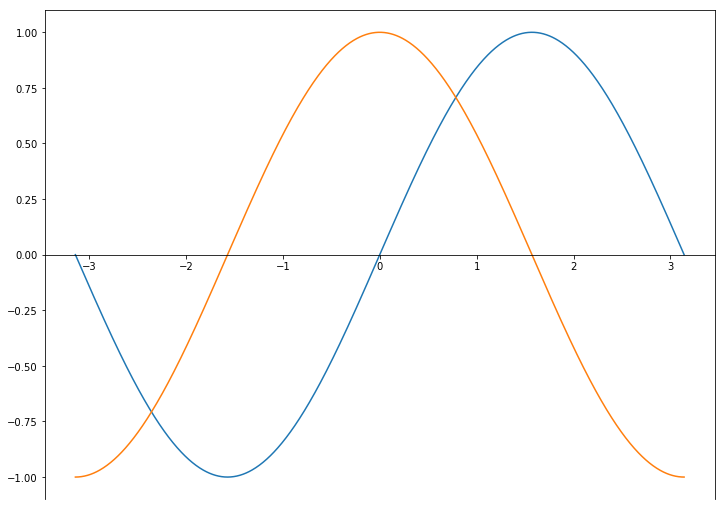

In [194]:
# Define the Taylor series.
# Note that this function does not account for array broadcasting.
def taylor_exp(x, tol=.0001):
    result = 0
    cur_term = x
    i = 1
    neg = False
    while anp.abs(cur_term) >= tol:
    # Autograd's version of NumPy doesn't have the math attribute so use NumPy.
        cur_term = x**i/np.math.factorial(i)
        if neg:
            result -= cur_term
            neg = False
        else:
            result += cur_term
            neg = True
        i += 2
    return result
# Compute the gradient.
d_taylor_exp = grad(taylor_exp)
# Note that differentiation in autograd only works with float values.
plt.subplots(figsize=(12, 9))
ax = plt.gca()
ax.spines["bottom"].set_position("zero")
plt.plot(domain, [taylor_exp(x) for x in domain])
plt.plot(domain, [d_taylor_exp(x) for x in domain])
plt.show()

In [221]:
x = sy.symbols('x')
y = sy.symbols('y')
X = sy.Matrix([(np.e ** x) * sy.sin(y) + y ** 3, 3 * y - sy.cos(x)])
Y = sy.Matrix([x, y])
f = lambda x: anp.array([(anp.e ** x[0]) * anp.sin(x[1]) + x[1] ** 3, 3 * x[1] - anp.cos(x[0])])
func_vec = np.array([lambda x: (np.e ** x[0]) * np.sin(x[1]) + x[1] ** 3, lambda x: 3 * x[1] - np.cos(x[0])])
x_vec = np.array([1, 1])
jac1 = sy.lambdify((x, y), X.jacobian(Y))(1, 1)
print('SymPy has an error of 0')
jac2 = jacobian(f)(anp.array([1.,1.]))
print('autograd has an error of {}'.format(np.linalg.norm(jac1 - jac2)))
jac3 = jacob(func_vec, x_vec, 1e-10)
print('c2 has an error of {}'.format(np.linalg.norm(jac1 - jac3)))
print('--------------------------------------------------------------------')
print('%timeit for SymPy')
%timeit sy.lambdify((x, y), X.jacobian(Y))(1, 1)
print('%timeit for autograd')
%timeit jacobian(f)(anp.array([1.,1.]))
print('%timeit for c2')
%timeit jacob(func_vec, x_vec, 1e-10)
print('--------------------------------------------------------------------')
print('autograd jacobian:\n')
print(jac2)

SymPy has an error of 0
autograd has an error of 4.3737714791252564e-15
c2 has an error of 3.6002670017755062e-06
--------------------------------------------------------------------
%timeit for SymPy
100 loops, best of 3: 4.71 ms per loop
%timeit for autograd
1000 loops, best of 3: 1.06 ms per loop
%timeit for c2
10000 loops, best of 3: 43.8 µs per loop
--------------------------------------------------------------------
autograd jacobian:

[[ 2.28735529  4.46869394]
 [ 0.84147098  3.        ]]
